In [1]:
# import sys
# !{sys.executable} -m pip install ing_theme_matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
# import qbstyles
# from ing_theme_matplotlib import mpl_style
import glacierml as gl
from tqdm import tqdm

# Step 1: Organize the data

## A. Load and organize the Glathida dataset

In [2]:
# raw_dataset = pd.read_csv('/data/fast0/datasets/glathida-3.1.0/data/T.csv')
TT = pd.read_csv('/home/sa42/data/glac/T_models/TT.csv')
glathida = TT
glathida = glathida[[
#     'GlaThiDa_ID',
#     'POLITICAL_UNIT',
#     'GLACIER_NAME',
#     'SURVEY_DATE',
    'LOWER_BOUND',
    'UPPER_BOUND',
    'AREA',
    'MEAN_SLOPE',
    'MEAN_THICKNESS',
#     'MEAN_THICKNESS_UNCERTAINTY',
#     'MAXIMUM_THICKNESS',
#     'MAX_THICKNESS_UNCERTAINTY',
#     'DATA_FLAG',
#     'REMARKS'
]]

# glathida = glathida.dropna()
glathida

,LOWER_BOUND,UPPER_BOUND,AREA,MEAN_SLOPE,MEAN_THICKNESS
0,2250,2270,0.01100,12.0,43
1,2270,2290,0.01400,15.0,36
2,2290,2310,0.01500,18.0,29
3,2310,2330,0.02100,25.0,22
4,2330,2350,0.03800,18.0,19
...,...,...,...,...,...
407,4800,4900,0.55900,23.0,44
408,4900,5000,0.54500,26.0,19
409,5000,5100,0.37900,24.0,3
410,5100,5200,0.01600,32.0,0


### separate out features - what will be trained to predict desired attribute

In [3]:
train_dataset = glathida.sample(frac=0.8, random_state=0)
test_dataset = glathida.drop(train_dataset.index)

train_features = train_dataset.copy()
test_features = test_dataset.copy()

#define label - attribute training to be picked
train_labels = train_features.pop('MEAN_THICKNESS')
test_labels = test_features.pop('MEAN_THICKNESS')

train_features.describe().transpose()[['mean', 'std']]

,mean,std
LOWER_BOUND,3045.490909,776.333798
UPPER_BOUND,3090.975758,793.486910
AREA,0.178350,0.379440
MEAN_SLOPE,22.442368,10.414711


# Step 2: Setup the Model

### Establish normalization layers

In [4]:
normalizer = {}
variable_list = list(train_features)
for variable_name in tqdm(variable_list):

    normalizer[variable_name] = gl.preprocessing.Normalization(input_shape=[1,], axis=None)
    normalizer[variable_name].adapt(np.array(train_features[variable_name]))
    
    
normalizer['ALL'] = gl.preprocessing.Normalization(axis=-1)
normalizer['ALL'].adapt(np.array(train_features))

  0%|          | 0/4 [00:00<?, ?it/s]2022-03-19 23:15:06.876521: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-19 23:15:06.876559: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sermeq.ess.washington.edu): /proc/driver/nvidia/version does not exist
2022-03-19 23:15:06.876965: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


In [5]:
linear_model = {}
linear_history = {}
linear_results = {}

# Linear regression

In [6]:
%%time
for variable_name in tqdm(variable_list):

    linear_model[variable_name] = gl.build_linear_model(normalizer[variable_name])
    linear_history[variable_name] = linear_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1,
                                        verbose=0,
                                        validation_split = 0.2)
    
    
    linear_results[variable_name] = linear_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

CPU times: user 1.7 s, sys: 211 ms, total: 1.91 s
Wall time: 1.58 s


In [7]:
# fig,ax=plt.subplots(2,6,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
# #     mpl_style("dark")
#     ax = plt.subplot(4,4,i+1)
#     plt.subplot(4,4,i+1)
#     gl.plot_loss(linear_history[variable_name])
#     ax.set_title(variable_name)
# #     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_loss.eps")

# Linear regression with multiple inputs

In [8]:
linear_model = gl.build_linear_model(normalizer['ALL'])

linear_history['MULTI'] = linear_model.fit(
train_features, train_labels,        
   epochs=1,
   verbose=0,
   validation_split = 0.2)

linear_results['MULTI'] = linear_model.evaluate(
    test_features,
    test_labels, verbose=0)

In [9]:
# gl.plot_loss(history_full)
# # plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_full_loss.eps")

# DNN regression

## Define regression functions

In [10]:
# test_results = {}
dnn_model = {}
dnn_history = {}
dnn_results = {}

In [11]:
for variable_name in tqdm(variable_list):

    dnn_model[variable_name] = gl.build_dnn_model(normalizer[variable_name])
    dnn_history[variable_name] = dnn_model[variable_name].fit(
                                        train_features[variable_name], train_labels,        
                                        epochs=1,
                                        verbose=0,
                                        validation_split = 0.2)
    dnn_results[variable_name] = dnn_model[variable_name].evaluate(
                                        test_features[variable_name],
                                        test_labels, verbose=0)

100%|██████████| 4/4 [00:01<00:00,  2.36it/s]


In [12]:
# fig,ax=plt.subplots(4,4,figsize=(10,10))
# for i, variable_name in enumerate(variable_list):
#     plt.subplot(4,4,i+1)
#     xmax = np.max(train_features[variable_name])
#     xmin = np.min(train_features[variable_name])
#     x = tf.linspace(xmin, xmax, 101)
#     y = dnn_model[variable_name].predict(x)
#     plot_single_model_variable(x,y,variable_name)

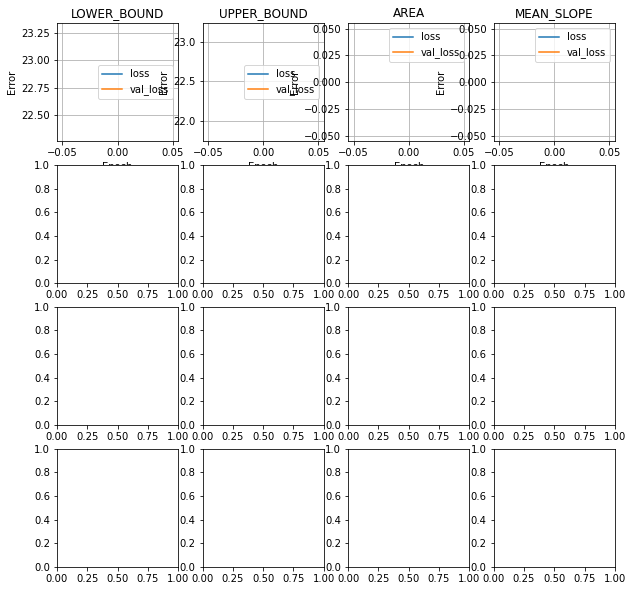

In [13]:
fig,ax=plt.subplots(4,4,figsize=(10,10))
for i, variable_name in enumerate(variable_list):
    ax = plt.subplot(4,4,i+1)
    gl.plot_loss(dnn_history[variable_name])
    ax.set_title(variable_name)
#     plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_loss.eps")

# Full model

In [14]:
dnn_full_model = gl.build_dnn_model(normalizer['ALL'])

In [15]:
%%time
dnn_history['MULTI'] = dnn_full_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=1)

dnn_results['MULTI'] = dnn_full_model.evaluate(
    test_features,
    test_labels, verbose=0)

CPU times: user 455 ms, sys: 125 ms, total: 580 ms
Wall time: 416 ms


<function glacierml.plot_loss(history)>

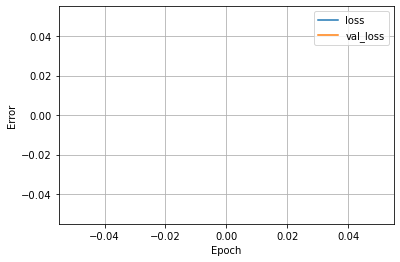

In [16]:
gl.plot_loss(dnn_history['MULTI'])
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_dnn_full_loss.png")

(0.0, 200.0)

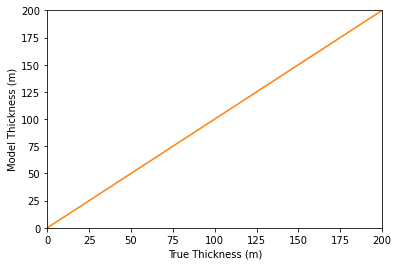

In [17]:
y = dnn_full_model.predict(test_features)
plt.plot(test_labels,y,'.')
plt.plot((0,200),(0,200),'-')
plt.xlabel('True Thickness (m)')
plt.ylabel('Model Thickness (m)')
plt.xlim((0,200))
plt.ylim((0,200))
# plt.savefig("/home/sa42/notebooks/glac/figs/GTP1_res.EPS")

# Collect Results

In [18]:
dfs = pd.DataFrame()
for variable_name in list(dnn_history):    
    df1 = pd.DataFrame(dnn_history[variable_name].history)
    df2 = pd.DataFrame(linear_history[variable_name].history)
    df1 = df1.loc[[df1.last_valid_index()]]
    df2 = df2.loc[[df2.last_valid_index()]]
    df1['Architecture'] = 'DNN'
    df2['Architecture'] = 'Linear'
    df1.insert(0, 'Variable', [variable_name])
    df2.insert(0, 'Variable', [variable_name])
    df = pd.concat([df1,df2])
    dfs = dfs.append(df)
df = dfs[[
    'Architecture',
    'Variable',
    'loss',
    'val_loss'
]]
df = df.sort_values(by=['Architecture','Variable'], ascending=[False,False])
print(df.to_latex(index=False))

KeyError: "None of [Index([None], dtype='object')] are in the [index]"

In [ ]:
crash()

# RGI merge